## Задание

### Часть 1 (5 балла)
1. Выберите одну любую из задач, рассмотренных на [лекции](https://colab.research.google.com/drive/1B7Np_7y002NLiuNkriq6a6MchQL4Fw7p?usp=sharing) (локализация, сегментация, перенос стиля, генерация).

2. Подберите на kaggle датасет, подходящий для решения этой задачи.
  - Вариант 1: если данные обладают необходимой разметкой, то повторите пайплайн из блокнота с примером на своих данных.
  - Вариант 2: если данные не обладают необходимой разметкой, то используйте модель, которую дообучали в примере, но без дообучения.
3. Оцените и прокомментируйте результат.

### Часть 2 (8 баллов)
1. Выберите еще одну из рассмотренных в лекции задач (не совпадающую с первой).
2. Если ваши данные обладают разметкой, необходимой для новой задачи, продолжите работу с ними. Если нет, найдите другой датасет, в котором она будет. Можно взять какой-нибудь стандартный в PyTorch, но такой, который не встречался ни в одном из примеров с лекции. В этом задании обязательно нужно найти датасет с разметкой.
3. Повторите пайплайн из примера.
4. Постарайтесь улучшить качество результата (если классификация - точность выше 90%, во всех остальных - максимально понизить лосс). Это можно сделать за счет настройки гиперпараметров. Можно (опционально и в зависимости от задачи) также поменять гиперпараметры в слоях нейронных сетей и/или порядок слоев и/или их количество.

В заданиях, где перечислены два варианта выполнения, нужно выбрать только один. Выполнение обоих дополнительных баллов не дает.



## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе тестов нет.
- Эту работу можно выполнить с кем-нибудь в паре или в гордом одиночестве.
- Пул-реквест нужно сделать в ветку `lab3`. Если вас двое, то можно 1 или 2 пул-реквеста, главное – отметьте как-нибудь, что выполняли в паре.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**

# Часть 2. Сегментация

In [1]:
!pip install segmentation-models-pytorch


import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
from torchvision.datasets import OxfordIIITPet
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import cv2


root_dir = './data'
dataset = datasets.OxfordIIITPet(root=root_dir, download=True)
images_dir = os.path.join(root_dir, 'oxford-iiit-pet', 'images')
masks_dir = os.path.join(root_dir, 'oxford-iiit-pet', 'annotations', 'trimaps')

data = {'images': [], 'masks': []}
for img_name in os.listdir(images_dir):
    mask_name = img_name.replace('.jpg', '.png')
    image_path = os.path.join(images_dir, img_name)
    mask_path = os.path.join(masks_dir, mask_name)

    if os.path.exists(image_path) and os.path.exists(mask_path):
        data['images'].append(image_path)
        data['masks'].append(mask_path)

df = pd.DataFrame(data)
df = df.head(1000)
df.to_csv('./data/pet_data_filtered_1000.csv', index=False)


df = pd.read_csv('./data/pet_data_filtered_1000.csv')
df.head()



  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=9fb5ee89a2b1be8daba2b042e0a4e225503c1a46eee1a62c130613680d48948b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=ffc9a206adbbfe82aa4390a84d7ea3ce3791d0c4398f565b564d6a5a81410169
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


100%|██████████| 792M/792M [00:51<00:00, 15.4MB/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 7.27MB/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


,images,masks
0,./data/oxford-iiit-pet/images/american_pit_bul...,./data/oxford-iiit-pet/annotations/trimaps/ame...
1,./data/oxford-iiit-pet/images/Sphynx_80.jpg,./data/oxford-iiit-pet/annotations/trimaps/Sph...
2,./data/oxford-iiit-pet/images/boxer_149.jpg,./data/oxford-iiit-pet/annotations/trimaps/box...
3,./data/oxford-iiit-pet/images/miniature_pinsch...,./data/oxford-iiit-pet/annotations/trimaps/min...
4,./data/oxford-iiit-pet/images/chihuahua_175.jpg,./data/oxford-iiit-pet/annotations/trimaps/chi...


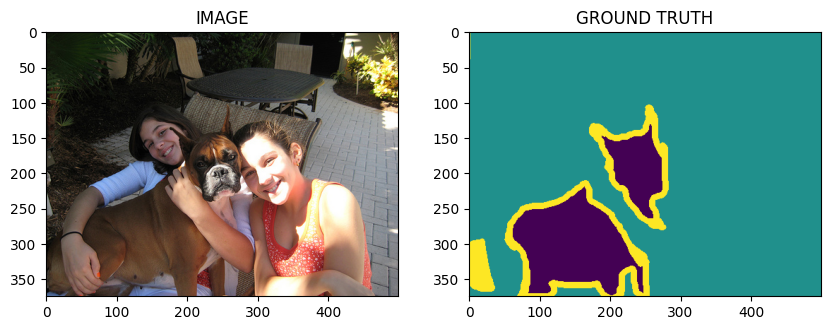

In [2]:
row = df.iloc[2]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask);



In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


import albumentations as A

image_size = 320

def get_train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],
      is_check_shapes=False)

def get_test_augs():
  return A.Compose([
      A.Resize(image_size, image_size)
  ],
      is_check_shapes=False)


class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask == 2] = 0
        mask[mask == 3] = 1

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data["image"]
            mask = data["mask"]
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.expand_dims(mask, axis=0).astype(np.float32)
        return image, mask

trainset = SegmentationDataset(train_df, get_train_augs())
testset = SegmentationDataset(test_df, get_test_augs())

print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(testset)}")



Size of Trainset : 800
Size of Validset : 200


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
testloader = DataLoader(testset, batch_size=8)

print(f"Number of batches in trainloader: {len(trainloader)}")
print(f"Number of batches in testloader: {len(testloader)}")

for image, mask in trainloader:
  break
print(f"Batch image shape: {image.shape}")
print(f"Batch mask shape: {mask.shape}")

Number of batches in trainloader: 100
Number of batches in testloader: 25
Batch image shape: torch.Size([8, 3, 320, 320])
Batch mask shape: torch.Size([8, 1, 320, 320])


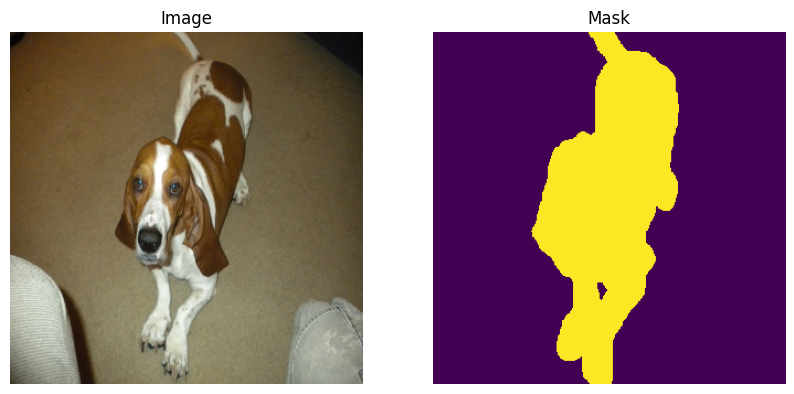

In [5]:
def show_image_and_mask(image, mask):
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image)
    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()
    else:
        image_np = image_np

    if isinstance(mask, torch.Tensor):
        mask_np = mask.squeeze().numpy()
    else:
        mask_np = mask.squeeze()

    image_np = image_np / 255.0 if image_np.max() > 1 else image_np

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, vmin=0, vmax=1)
    plt.title("Mask")
    plt.axis("off")
    plt.show()

idx = 17
image, mask = trainset[idx]
show_image_and_mask(image, mask)

In [6]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.architecture = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.architecture(images)
        if masks is not None:
          loss1 = smp.losses.DiceLoss(mode="binary")(logits, masks)
          loss2 = nn.BCEWithLogitsLoss()(logits, masks)
          return logits, loss1 + loss2
        return logits

model = SegmentationModel()
model.to(dev)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 188MB/s]


SegmentationModel(
  (architecture): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.0003)

def train_fn(loader, model, optimizer):
    model.train()
    total_loss = 0

    for images, masks in tqdm(loader):
      images = images.to(dev)
      masks = masks.to(dev)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    return total_loss / len(loader)


def eval_fn(loader, model):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(loader):
      images = images.to(dev)
      masks = masks.to(dev)

    logits, loss = model(images, masks)

    total_loss += loss.item()
  return total_loss / len(loader)


best_test_loss = float('inf')

for epoch in range(40):
    train_loss = train_fn(trainloader, model, optimizer)
    test_loss = eval_fn(testloader, model)

    if test_loss < best_test_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_test_loss = test_loss
        print(f"Epoch {epoch+1} Test Loss: {test_loss} Train Loss: {train_loss}")



100%|██████████| 25/25 [00:01<00:00, 21.95it/s]


Epoch 1 Test Loss: 0.04925148963928223 Train Loss: 0.013291511535644531


100%|██████████| 25/25 [00:01<00:00, 21.98it/s]


Epoch 2 Test Loss: 0.047616806030273434 Train Loss: 0.011824374198913573


100%|██████████| 25/25 [00:01<00:00, 22.22it/s]


Epoch 3 Test Loss: 0.04634120464324951 Train Loss: 0.011026523113250732


100%|██████████| 25/25 [00:01<00:00, 14.80it/s]


Epoch 4 Test Loss: 0.045403337478637694 Train Loss: 0.010718541145324707


100%|██████████| 25/25 [00:01<00:00, 13.99it/s]


Epoch 5 Test Loss: 0.04369858741760254 Train Loss: 0.00977415382862091


100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


Epoch 6 Test Loss: 0.042083845138549805 Train Loss: 0.009857873916625976


100%|██████████| 25/25 [00:01<00:00, 21.33it/s]


Epoch 7 Test Loss: 0.03924085378646851 Train Loss: 0.009137439727783202


100%|██████████| 25/25 [00:01<00:00, 21.79it/s]


Epoch 8 Test Loss: 0.036408586502075194 Train Loss: 0.008614683151245117


100%|██████████| 25/25 [00:01<00:00, 22.10it/s]


Epoch 9 Test Loss: 0.034091079235076906 Train Loss: 0.008492775559425354


100%|██████████| 25/25 [00:01<00:00, 22.18it/s]


Epoch 10 Test Loss: 0.03243134021759033 Train Loss: 0.007941819429397583


100%|██████████| 25/25 [00:01<00:00, 13.84it/s]


Epoch 11 Test Loss: 0.031603884696960446 Train Loss: 0.0075200068950653075


100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


Epoch 12 Test Loss: 0.030640676021575927 Train Loss: 0.007464333772659302


100%|██████████| 25/25 [00:01<00:00, 21.75it/s]


Epoch 13 Test Loss: 0.029691336154937745 Train Loss: 0.007334837913513184


100%|██████████| 25/25 [00:01<00:00, 21.17it/s]


Epoch 14 Test Loss: 0.02851048707962036 Train Loss: 0.00743556261062622


100%|██████████| 25/25 [00:01<00:00, 22.01it/s]


Epoch 15 Test Loss: 0.02841653108596802 Train Loss: 0.007124602794647217


100%|██████████| 25/25 [00:01<00:00, 21.90it/s]


Epoch 16 Test Loss: 0.027284314632415773 Train Loss: 0.006580954790115357


100%|██████████| 25/25 [00:01<00:00, 18.55it/s]


Epoch 17 Test Loss: 0.025584537982940674 Train Loss: 0.006475023031234741


100%|██████████| 25/25 [00:01<00:00, 13.23it/s]


Epoch 18 Test Loss: 0.02455864667892456 Train Loss: 0.006350880861282349


100%|██████████| 25/25 [00:01<00:00, 18.25it/s]


Epoch 19 Test Loss: 0.022474548816680907 Train Loss: 0.0067832165956497196


100%|██████████| 25/25 [00:01<00:00, 21.97it/s]


Epoch 20 Test Loss: 0.02099492073059082 Train Loss: 0.0065301692485809325


100%|██████████| 25/25 [00:01<00:00, 22.01it/s]


Epoch 21 Test Loss: 0.020706489086151122 Train Loss: 0.0073439210653305055


100%|██████████| 25/25 [00:01<00:00, 22.00it/s]


Epoch 23 Test Loss: 0.020603263378143312 Train Loss: 0.00549786388874054


100%|██████████| 25/25 [00:01<00:00, 13.74it/s]


Epoch 24 Test Loss: 0.019719650745391847 Train Loss: 0.005640372633934021


100%|██████████| 25/25 [00:01<00:00, 14.44it/s]


Epoch 25 Test Loss: 0.019660241603851318 Train Loss: 0.005883933305740357


100%|██████████| 25/25 [00:01<00:00, 21.79it/s]


Epoch 26 Test Loss: 0.018996293544769286 Train Loss: 0.00658002495765686


100%|██████████| 25/25 [00:01<00:00, 22.02it/s]


Epoch 27 Test Loss: 0.018980185985565185 Train Loss: 0.005189051032066345


100%|██████████| 25/25 [00:01<00:00, 21.66it/s]


Epoch 29 Test Loss: 0.018497493267059326 Train Loss: 0.004976893663406372


100%|██████████| 25/25 [00:01<00:00, 15.73it/s]


Epoch 30 Test Loss: 0.01810695171356201 Train Loss: 0.004714592695236206


100%|██████████| 25/25 [00:01<00:00, 12.98it/s]


Epoch 31 Test Loss: 0.01768953800201416 Train Loss: 0.004641386866569519


100%|██████████| 25/25 [00:01<00:00, 18.55it/s]


Epoch 32 Test Loss: 0.017130671739578246 Train Loss: 0.004915449023246765


100%|██████████| 25/25 [00:01<00:00, 21.98it/s]


Epoch 33 Test Loss: 0.016309397220611574 Train Loss: 0.006339753270149231


100%|██████████| 25/25 [00:01<00:00, 22.03it/s]


Epoch 34 Test Loss: 0.015967729091644286 Train Loss: 0.005396301746368408


100%|██████████| 25/25 [00:01<00:00, 21.46it/s]


Epoch 35 Test Loss: 0.015002822875976563 Train Loss: 0.006772446632385254


100%|██████████| 25/25 [00:01<00:00, 22.05it/s]


Epoch 36 Test Loss: 0.01463288426399231 Train Loss: 0.0053448909521102905


100%|██████████| 25/25 [00:01<00:00, 21.74it/s]


<ipython-input-8-293a0f80f456>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


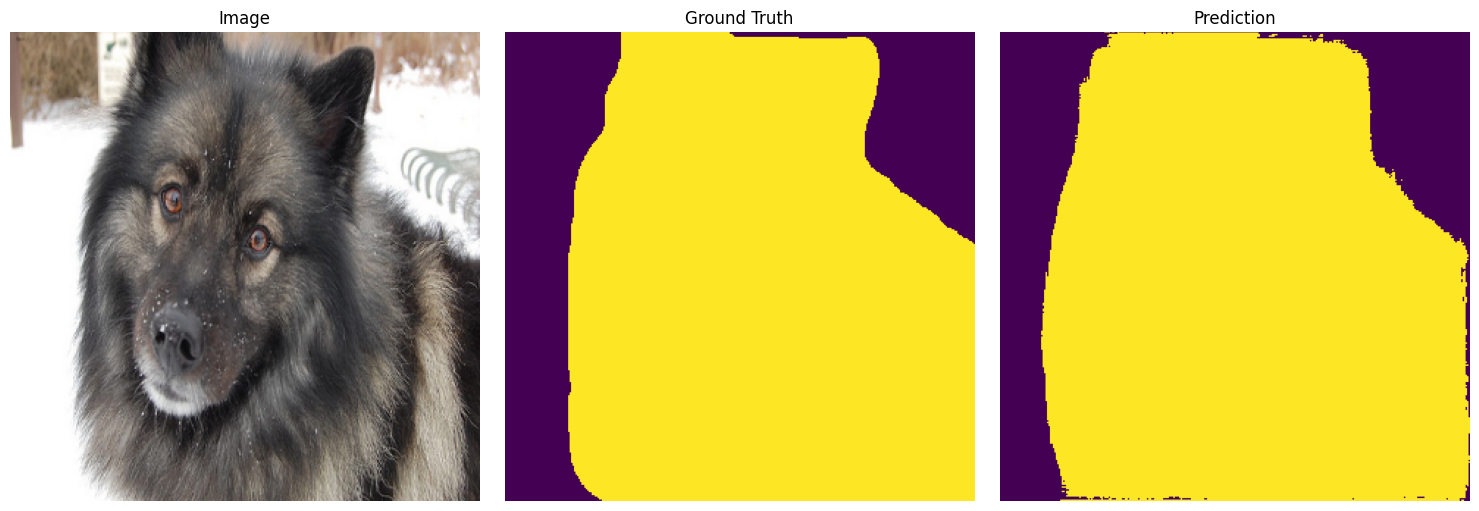

In [8]:
model.load_state_dict(torch.load("best_model.pt"))

idx = 1
image, mask = testset[idx]

image_tensor = torch.tensor(image).to(dev).unsqueeze(0)

with torch.no_grad():
    pred_mask = torch.sigmoid(model(image_tensor))
    pred_mask = (pred_mask > 0.5).float()

f, axarr = plt.subplots(1, 3, figsize=(15, 5))

image_np = image_tensor.cpu().squeeze().permute(1, 2, 0).numpy()

if image_np.max() > 1:
    image_np = image_np / 255.0

axarr[0].imshow(image_np)
axarr[0].set_title("Image")
axarr[0].axis("off")

axarr[1].imshow(mask.squeeze(), vmin=0, vmax=1)
axarr[1].set_title("Ground Truth")
axarr[1].axis("off")

pred_mask_np = pred_mask.squeeze().cpu().numpy()
axarr[2].imshow(pred_mask_np, vmin=0, vmax=1)
axarr[2].set_title("Prediction")
axarr[2].axis("off")

plt.tight_layout()
plt.show()